In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

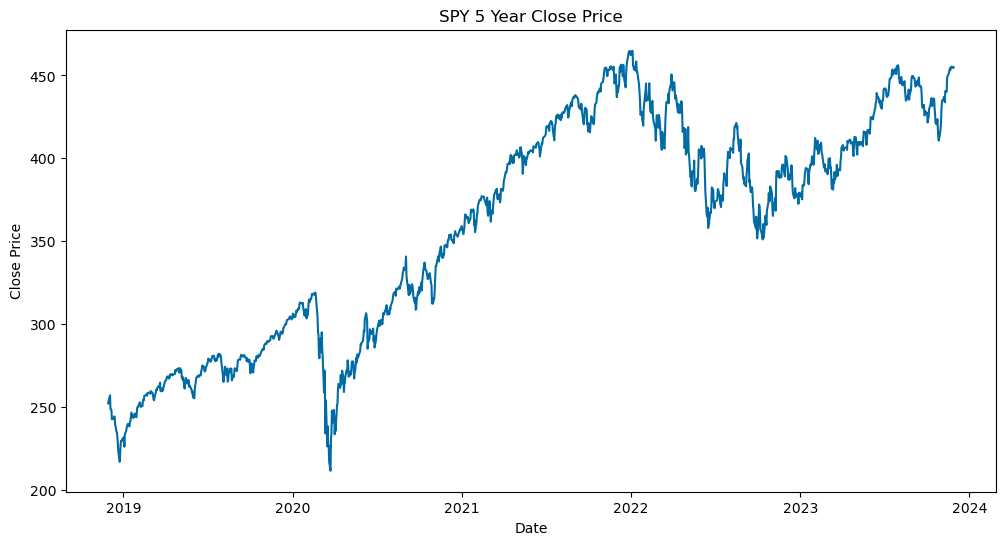

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=301.981378, mean2=415.498863, mean_percent_diff=37.590889
variance1=2093.758018, variance2=688.582007, var_percent_diff=-67.112627


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.362983
p-value: 0.599888
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.907688070029732, 0.01, 20, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.91
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

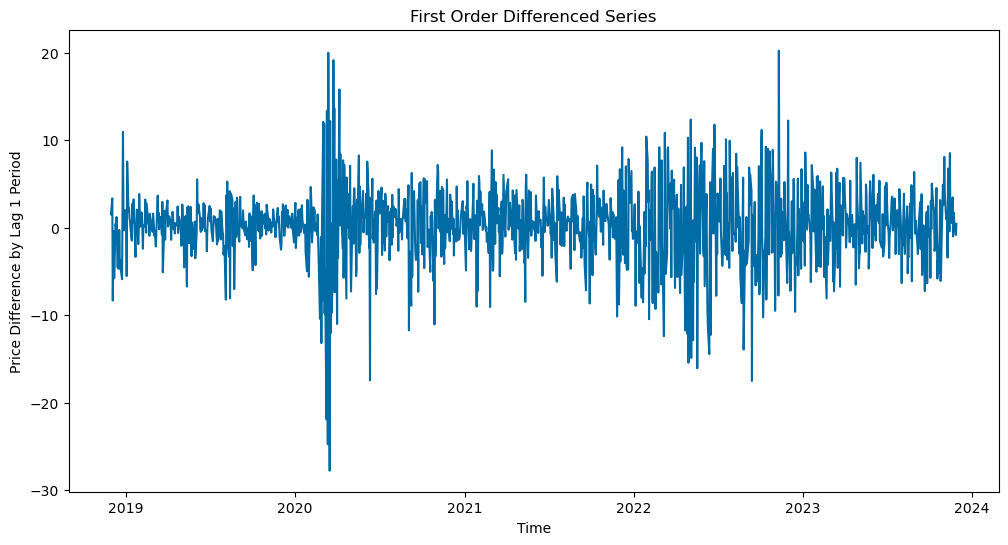

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.893196
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3042.1767857437394
BIC = 3052.0022713847256
Time Series Evaluation Metrics
MSE = 1011.4026399402715
MAE = 25.96456424789731
RMSE = 31.802557128952248
MAPE = 0.06010738874130826
r2 = -0.9095068071448078



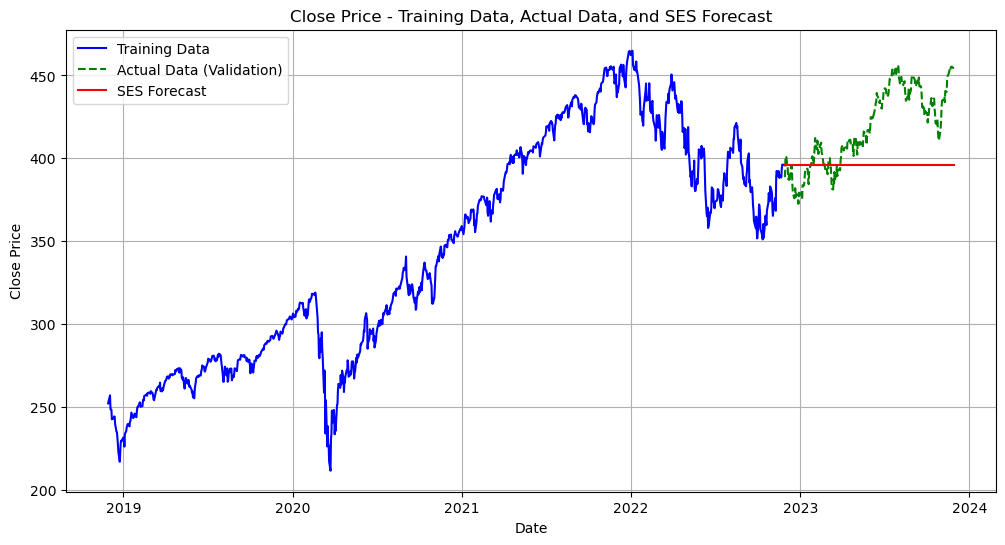

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

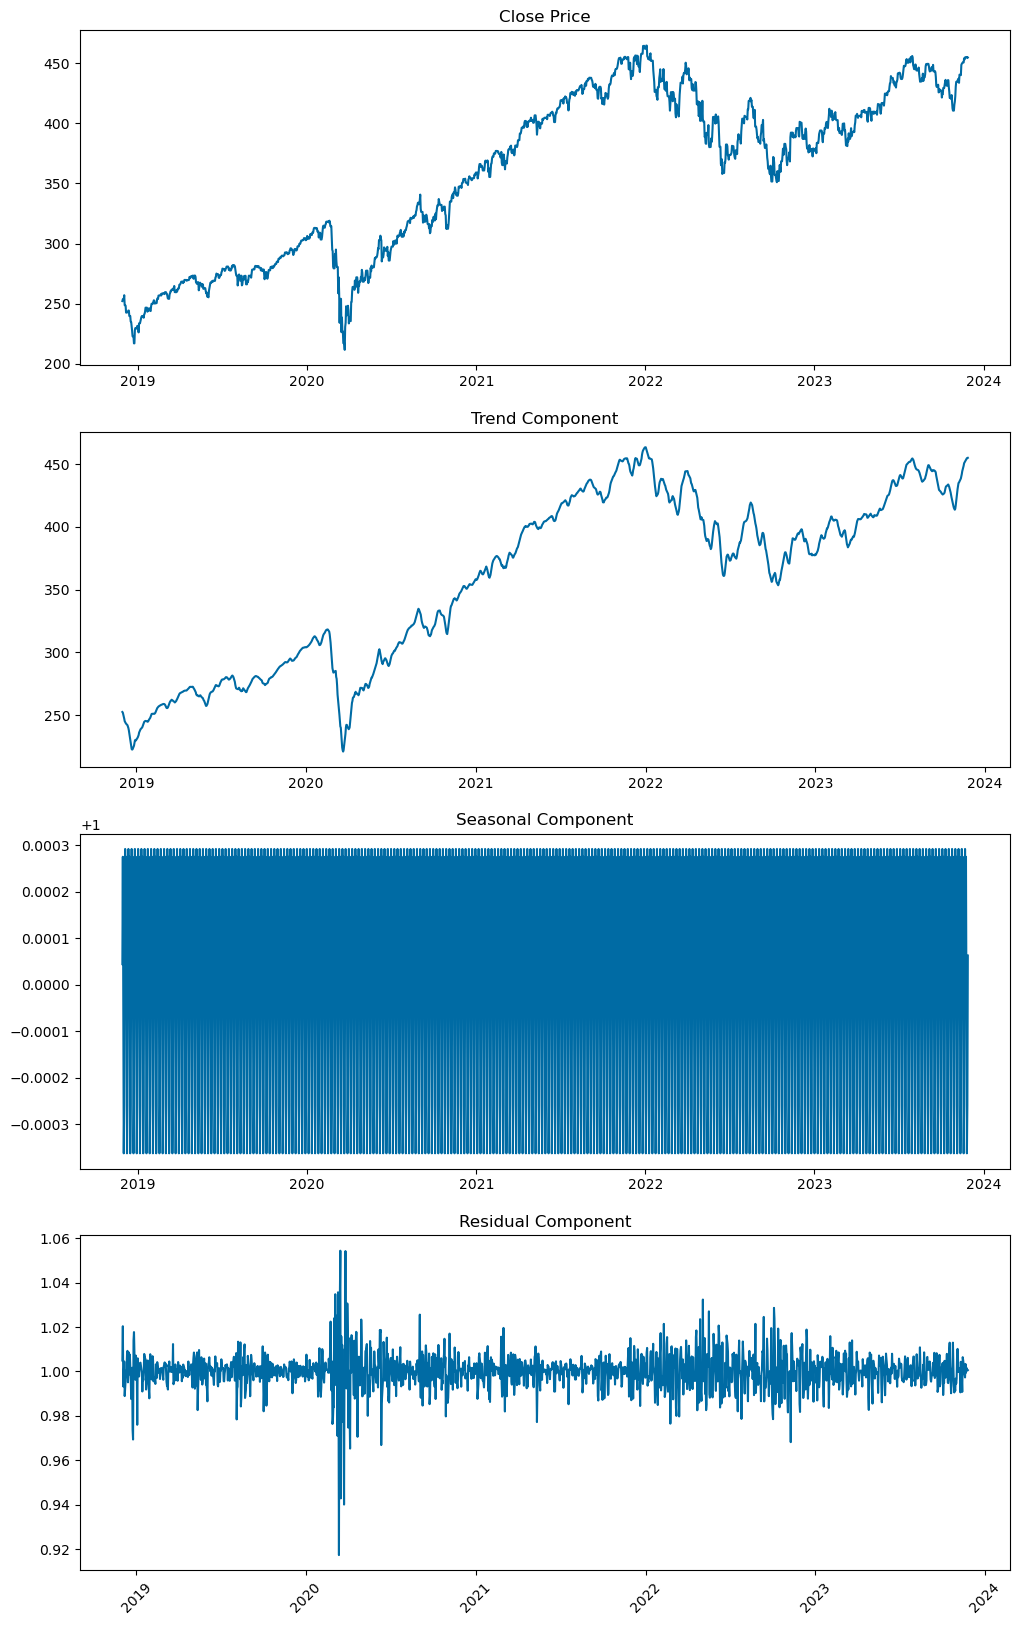

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

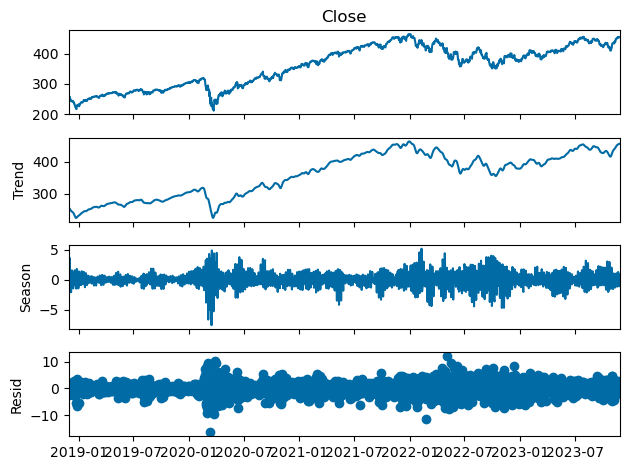

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

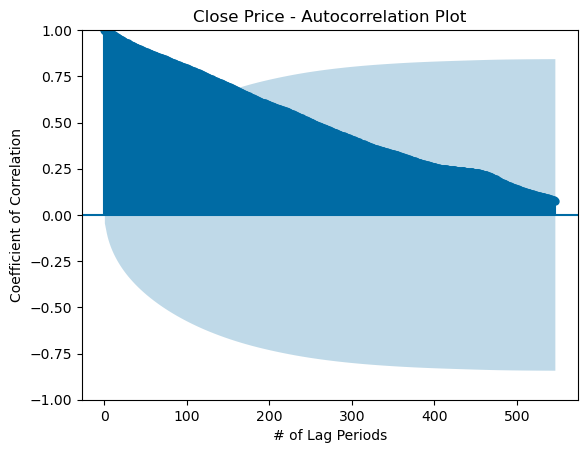

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

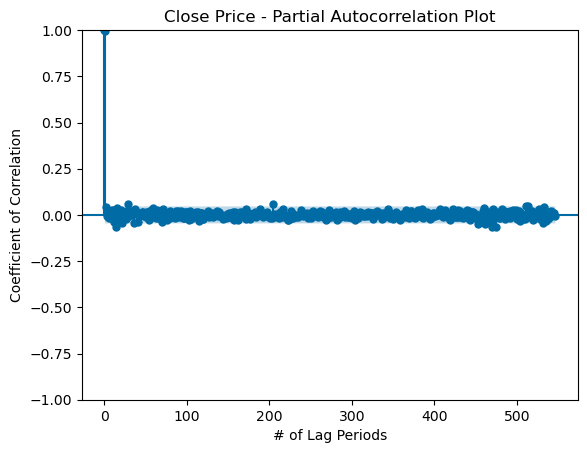

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

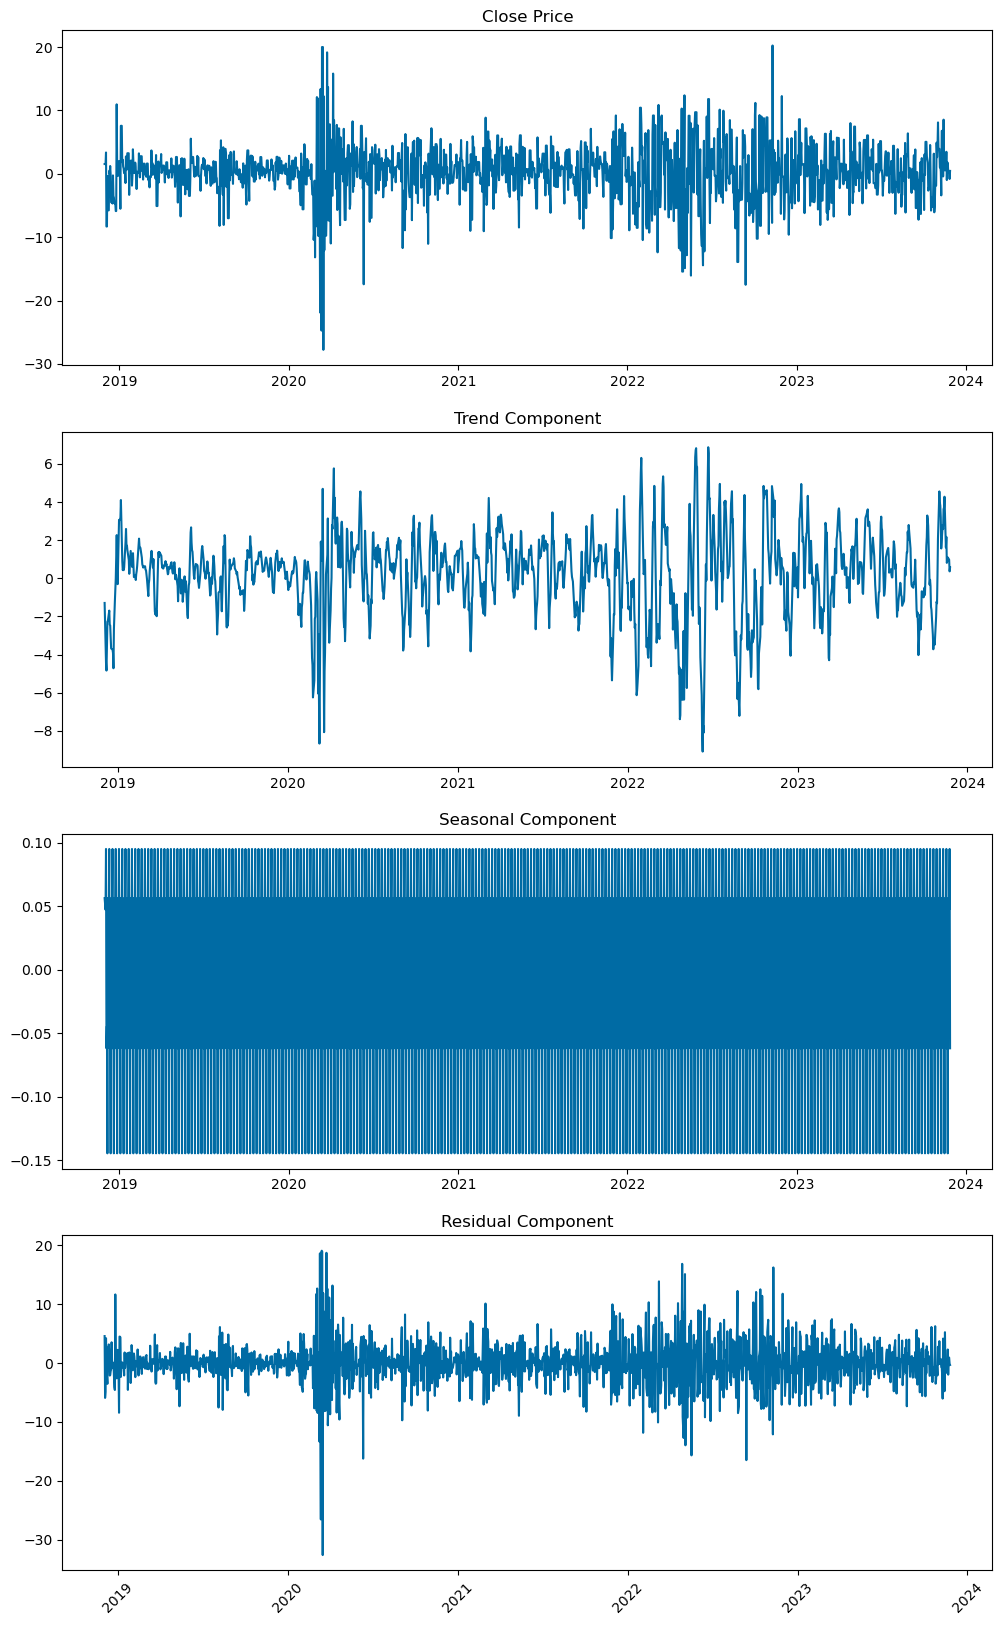

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

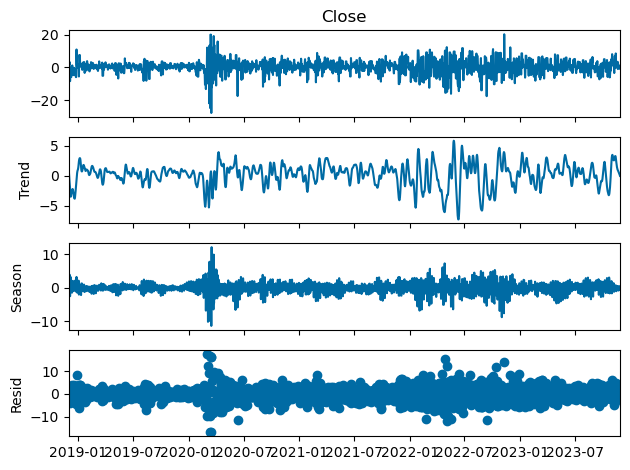

In [21]:
stl = STL(ts_lag_1).fit().plot()

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

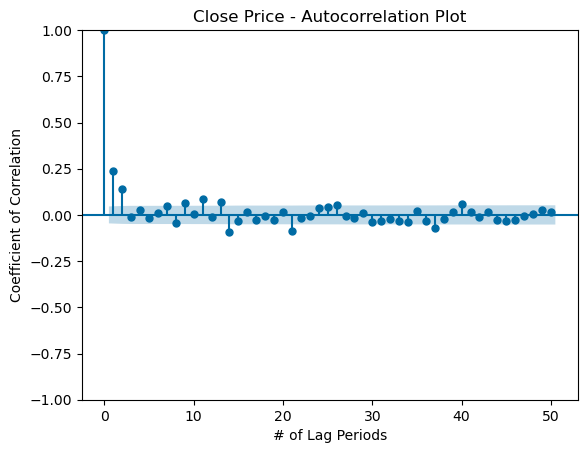

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

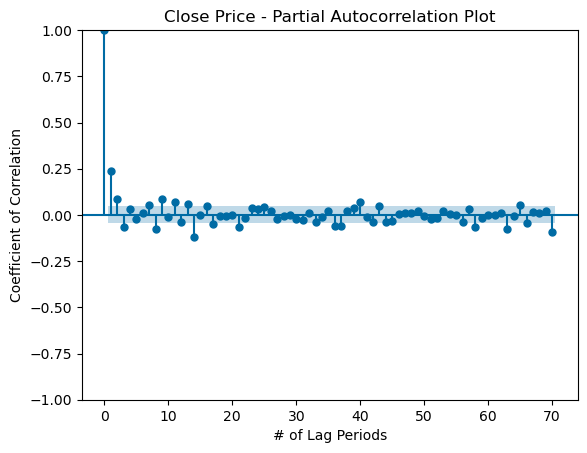

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for AR(1): 10450.845083054824
BIC for AR(1): 10467.371444566726


AIC for AR(2): 10439.147254667769
BIC for AR(2): 10461.182403350305


AIC for AR(3): 10433.90159009351
BIC for AR(3): 10461.445525946681


AIC for AR(8): 10425.397296020492
BIC for AR(8): 10480.485167726834


AIC for AR(9): 10413.280215786515
BIC for AR(9): 10473.876874663492


AIC for AR(11): 10408.062076233604
BIC for AR(11): 10479.67630945185


AIC for AR(14): 10377.47115359083
BIC for AR(14): 10465.611748320978


AIC for AR(21): 10375.140070563139
BIC for AR(21): 10501.842175487727




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for MA(0): 10482.237734053677
BIC for MA(0): 10564.86954161319


AIC for MA(1): 10377.47115359083
BIC for MA(1): 10465.611748320978


AIC for MA(2): 10406.66322005519
BIC for MA(2): 10500.312601955973


AIC for MA(11): 10371.82105686374
BIC for MA(11): 10515.049523300231


AIC for MA(13): 10362.288150828688
BIC for MA(13): 10516.534191606448


AIC for MA(14): 10367.77057896084
BIC for MA(14): 10527.525406909235


AIC for MA(21): 10371.8216119211
BIC for MA(21): 10570.137950063934


AIC for MA(37): 10359.576296561558
BIC for MA(37): 10646.03322943454


AIC for MA(40): 10363.095698392372
BIC for MA(40): 10666.078992777257




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10377.47115359083
BIC = 10465.611748320978
Time Series Evaluation Metrics
MSE = 175102.59864871105
MAE = 417.81922151573883
RMSE = 418.45262413887554
MAPE = 0.9995088697588778
r2 = -329.59000527050694



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3542.860695970794
BIC = 3577.249895714246
Time Series Evaluation Metrics
MSE = 970.5009391106372
MAE = 25.450774925923618
RMSE = 31.152864059515252
MAPE = 0.0589517545195745
r2 = -0.8322852604790809

Results for Seasonal Period 3
AIC = 3853.720536383085
BIC = 3893.0224789470303
Time Series Evaluation Metrics
MSE = 1011.7118332837082
MAE = 26.025866133158875
RMSE = 31.807417897146387
MAPE = 0.06027422861065878
r2 = -0.9100905576420888

Results for Seasonal Period 8
AIC = 4430.59262181895
BIC = 4494.458278485361
Time Series Evaluation Metrics
MSE = 1968.8114327833491
MAE = 41.999898221722646
RMSE = 44.37129063688985
MAPE = 0.1007551194071573
r2 = -2.7170743721870676

Results for Seasonal Period 9
AIC = 4448.5812199104175
BIC = 4517.359619397322
Time Series Evaluation Metrics
MSE = 2470.8836604111443
MAE = 47.08740912741273
RMSE = 49.707983869909114
MAPE = 0.11275335093098882
r2 = -3.6649761261218305

Results for Seasonal Period 11
AIC = 4536.0440617584

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3894.317679899216
BIC = 3928.706879642668
Time Series Evaluation Metrics
MSE = 2197.537654992406
MAE = 40.66487442227615
RMSE = 46.87790156344891
MAPE = 0.09628482024106079
r2 = -3.148904645347619

Results for Seasonal mul
AIC = 3892.5627988035662
BIC = 3926.9519985470183
Time Series Evaluation Metrics
MSE = 2446.094761981344
MAE = 42.980299645010994
RMSE = 49.458010089179126
MAPE = 0.10169166079523467
r2 = -3.6181752098259032

Results for Seasonal additive
AIC = 3894.317679899216
BIC = 3928.706879642668
Time Series Evaluation Metrics
MSE = 2197.537654992406
MAE = 40.66487442227615
RMSE = 46.87790156344891
MAPE = 0.09628482024106079
r2 = -3.148904645347619

Results for Seasonal multiplicative
AIC = 3892.5627988035662
BIC = 3926.9519985470183
Time Series Evaluation Metrics
MSE = 2446.094761981344
MAE = 42.980299645010994
RMSE = 49.458010089179126
MAPE = 0.10169166079523467
r2 = -3.6181752098259032

Results for Seasonal None
AIC = 4639.286582040023
BIC = 46

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3898.881580347512
BIC = 3933.2707800909643
Time Series Evaluation Metrics
MSE = 1237.5886702548762
MAE = 30.77578557818596
RMSE = 35.17937848022441
MAPE = 0.07337955103261434
r2 = -1.3365412516982706

Results for Trend mul
AIC = 3894.3175867745485
BIC = 3928.7067865180006
Time Series Evaluation Metrics
MSE = 2197.523697165864
MAE = 40.66473839282403
RMSE = 46.877752688944724
MAPE = 0.09628450176802908
r2 = -3.1488782932661215

Results for Trend additive
AIC = 3898.881580347512
BIC = 3933.2707800909643
Time Series Evaluation Metrics
MSE = 1237.5886702548762
MAE = 30.77578557818596
RMSE = 35.17937848022441
MAPE = 0.07337955103261434
r2 = -1.3365412516982706

Results for Trend multiplicative
AIC = 3894.3175867745485
BIC = 3928.7067865180006
Time Series Evaluation Metrics
MSE = 2197.523697165864
MAE = 40.66473839282403
RMSE = 46.877752688944724
MAPE = 0.09628450176802908
r2 = -3.1488782932661215

Results for Trend None
AIC = 3871.3165520626258
BIC = 3895.8802661

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [35]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3883.8817722969548
BIC = 3923.1837148609
Time Series Evaluation Metrics
MSE = 261.8754979689098
MAE = 13.740981874779841
RMSE = 16.182567718656696
MAPE = 0.033594661438818306
r2 = 0.5055845948497818

Results for Damped Trend False
AIC = 3894.317457144246
BIC = 3928.706656887698
Time Series Evaluation Metrics
MSE = 2197.5206326892476
MAE = 40.66470640991231
RMSE = 46.8777200031022
MAPE = 0.09628442647897521
r2 = -3.14887250759904



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [36]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3909.6595562982825
BIC = 3944.0487560417346
Time Series Evaluation Metrics
MSE = 1214.7850729271242
MAE = 30.47068122836499
RMSE = 34.85376698331364
MAPE = 0.07266796111147164
r2 = -1.2934885419215756

Results for Initialization Method estimated
AIC = 3893.4897696977664
BIC = 3927.8789694412185
Time Series Evaluation Metrics
MSE = 1238.4364928768487
MAE = 30.787066586128148
RMSE = 35.19142641151178
MAPE = 0.07340586259897201
r2 = -1.3381419228889282

Results for Initialization Method heuristic
AIC = 3898.8810845195953
BIC = 3933.2702842630474
Time Series Evaluation Metrics
MSE = 1237.589721098533
MAE = 30.775801187469117
RMSE = 35.179393415727525
MAPE = 0.07337958815835331
r2 = -1.3365432356688838

Results for Initialization Method legacy-heuristic
AIC = 3909.6595562982825
BIC = 3944.0487560417346
Time Series Evaluation Metrics
MSE = 1214.7850729271242
MAE = 30.47068122836499
RMSE = 34.85376698331364
MAPE = 0.07266796111147164
r2 = -1.293488

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [37]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3883.881404837021
BIC = 3923.1833474009663
Time Series Evaluation Metrics
MSE = 261.8759291801158
MAE = 13.740991371409505
RMSE = 16.182581041975837
MAPE = 0.03359468754161352
r2 = 0.5055837807321389

None


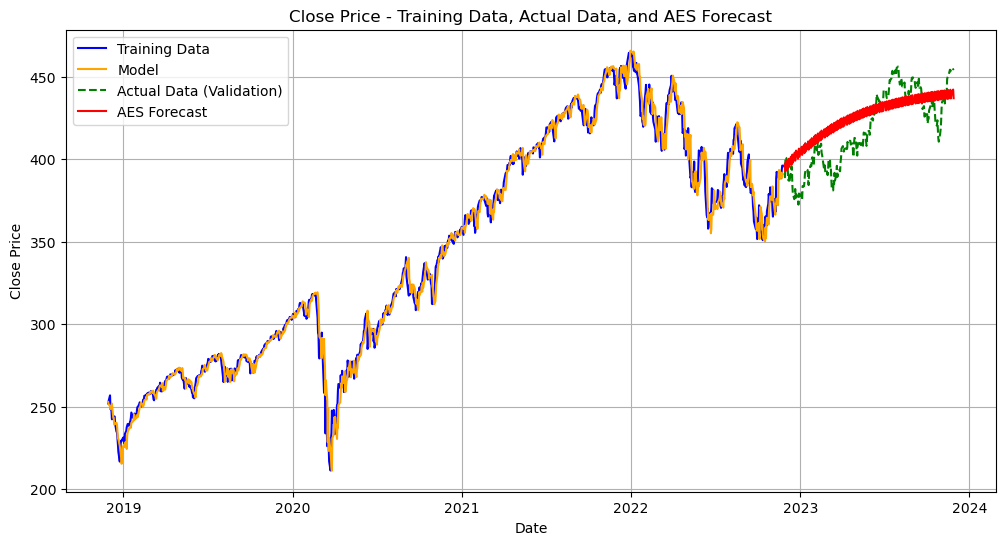

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [39]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3559.179887908901
BIC = 3593.569087652353
Time Series Evaluation Metrics
MSE = 294.52457844346645
MAE = 14.473543246976638
RMSE = 17.161718400074815
MAPE = 0.03438544995384872
r2 = 0.4439438209865988

None


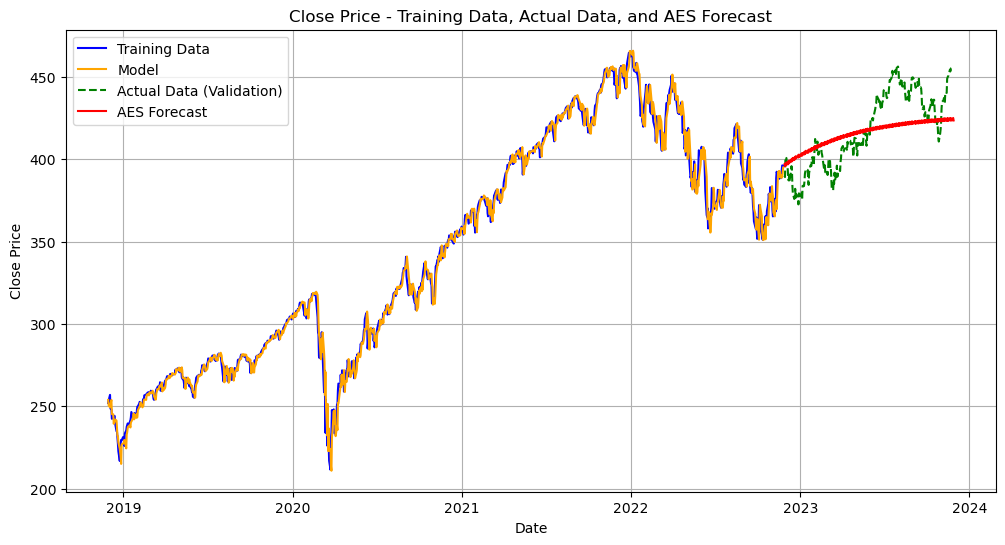

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [41]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2936.848
Date:                Tue, 28 Nov 2023   AIC                           5905.695
Time:                        17:14:43   BIC                           5990.241
Sample:                    11-29-2018   HQIC                          5937.238
                         - 11-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2004      1.053     -0.190      0.849      -2.264       1.863
ar.L2         -0.1192      0.154     -0.773      0.439      -0.422       0.183
ar.L3          0.1927      0.115      1.671      0.0

In [42]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

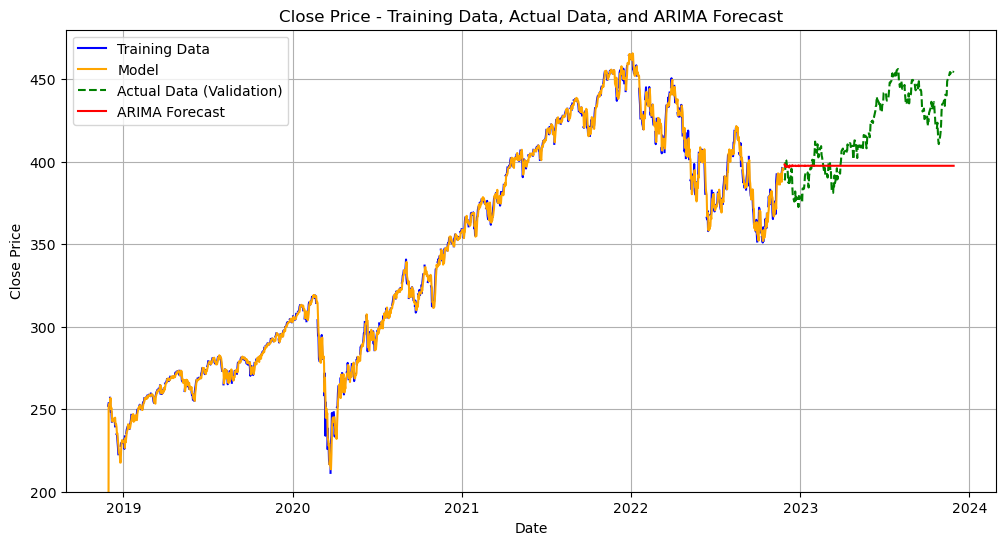

In [43]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [44]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

Open        High         Low       Close  \
Date                                                                        
2022-11-29 00:00:00-05:00  389.911913  391.142541  387.204534  389.104645   
2022-11-30 00:00:00-05:00  389.360615  401.361694  387.381787  401.361694   
2022-12-01 00:00:00-05:00  402.434756  403.645704  398.477070  401.066315   
2022-12-02 00:00:00-05:00  396.015825  401.538866  395.907545  400.603607   
2022-12-05 00:00:00-05:00  397.689508  398.654300  391.999089  393.397064   

                              Volume  open_close  positive   high_low  
Date                                                                   
2022-11-29 00:00:00-05:00   52310000   -0.807269         0   3.938007  
2022-11-30 00:00:00-05:00  144566700   12.001080         1  13.979908  
2022-12-01 00:00:00-05:00   76398200   -1.368442         0   5.168634  
2022-12-02 00:00:00-05:00   85342700    4.587782         1   5.631321  
2022-12-05 00:00:00-05:00   77289800   -4.292443         0   6.655212

In [45]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [46]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

Open       High        Low      Close  \
Date                                                                    
2022-12-12 00:00:00-05:00   1.151833   3.258681   1.417668   5.700256   
2022-12-13 00:00:00-05:00  14.846272  12.926512   5.710127   5.641205   
2022-12-14 00:00:00-05:00   6.566610   7.757879   3.111030   6.025146   
2022-12-15 00:00:00-05:00   0.187054  -3.642672  -5.434443  -9.175568   
2022-12-16 00:00:00-05:00 -22.910624 -21.791803 -16.027973 -16.677521   

                               Volume  open_close  positive  high_low  \
Date                                                                    
2022-12-12 00:00:00-05:00   9477900.0    4.548423       0.0  1.841013   
2022-12-13 00:00:00-05:00  63044600.0   -9.205067      -1.0  7.216385   
2022-12-14 00:00:00-05:00  26663600.0   -0.541464       0.0  4.646849   
2022-12-15 00:00:00-05:00  42300100.0   -9.362622      -1.0  1.791770   
2022-12-16 00:00:00-05:00  -3924500.0    6.233103       0.0 -5.763830   

                           Open_lag1  High_lag1  Low_lag1  Close_lag1  \
Date                                                                    
2022-12-12 00:00:00-05:00  -4.410557  -2.333243  1.486598   -0.541443   
2022-12-13 00:00:00-05:00   1.151833   3.258681  1.417668    5.700256   
2022-12-14 00:00:00-05:00  14.846272  12.926512  5.710127    5.641205   
2022-12-15 00:00:00-05:00   6.566610   7.757879  3.111030    6.025146   
2022-12-16 00:00:00-05:00   0.187054  -3.642672 -5.434443   -9.175568   

                           Volume_lag1  open_close_lag1  positive_lag1  \
Date                                                                     
2022-12-12 00:00:00-05:00    3475500.0         3.869114            0.0   
2022-12-13 00:00:00-05:00    9477900.0         4.548423            0.0   
2022-12-14 00:00:00-05:00   63044600.0        -9.205067           -1.0   
2022-12-15 00:00:00-05:00   26663600.0        -0.541464            0.0   
2022-12-16 00:00:00-05:00   42300100.0        -9.362622           -1.0   

                           high_low_lag1  Open_lag2  High_lag2  Low_lag2  \
Date                                                                       
2022-12-12 00:00:00-05:00      -3.819841  -8.673467  -7.452694 -4.824091   
2022-12-13 00:00:00-05:00       1.841013  -4.410557  -2.333243  1.486598   
2022-12-14 00:00:00-05:00       7.216385   1.151833   3.258681  1.417668   
2022-12-15 00:00:00-05:00       4.646849  14.846272  12.926512  5.710127   
2022-12-16 00:00:00-05:00       1.791770   6.566610   7.757879  3.111030   

                           Close_lag2  Volume_lag2  open_close_lag2  \
Date                                                                  
2022-12-12 00:00:00-05:00   -3.298096  -16551900.0         5.375371   
2022-12-13 00:00:00-05:00   -0.541443    3475500.0         3.869114   
2022-12-14 00:00:00-05:00    5.700256    9477900.0         4.548423   
2022-12-15 00:00:00-05:00    5.641205   63044600.0        -9.205067   
2022-12-16 00:00:00-05:00    6.025146   26663600.0        -0.541464   

                           positive_lag2  high_low_lag2  Open_lag1_lag2  \
Date                                                                      
2022-12-12 00:00:00-05:00            1.0      -2.628603       -9.165675   
2022-12-13 00:00:00-05:00            0.0      -3.819841       -8.673467   
2022-12-14 00:00:00-05:00            0.0       1.841013       -4.410557   
2022-12-15 00:00:00-05:00           -1.0       7.216385        1.151833   
2022-12-16 00:00:00-05:00            0.0       4.646849       14.846272   

                           High_lag1_lag2  Low_lag1_lag2  Close_lag1_lag2  \
Date                                                                        
2022-12-12 00:00:00-05:00      -12.030549     -10.012362       -13.536865   
2022-12-13 00:00:00-05:00       -7.452694      -4.824091        -3.298096   
2022-12-14 00:00:00-05:00       -2.333243       1.486598        -0.541443   
2022-12-15 00:00:00-05:00        3.

              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.86      0.68      0.76        28

    accuracy                           0.71        42
   macro avg       0.71      0.73      0.70        42
weighted avg       0.76      0.71      0.72        42



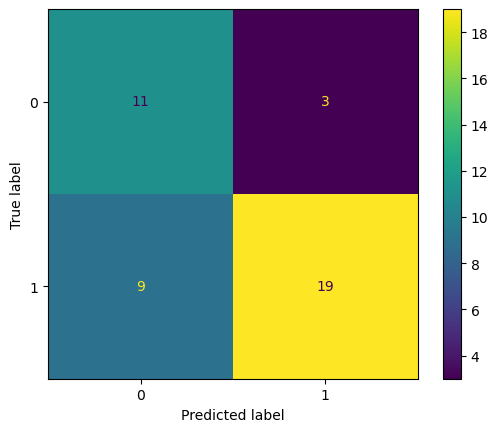

In [47]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

Lag = 1
              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.86      0.68      0.76        28

    accuracy                           0.71        42
   macro avg       0.71      0.73      0.70        42
weighted avg       0.76      0.71      0.72        42



Lag = 2
              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.86      0.68      0.76        28

    accuracy                           0.71        42
   macro avg       0.71      0.73      0.70        42
weighted avg       0.76      0.71      0.72        42



Lag = 3
              precision    recall  f1-score   support

           0       0.55      0.79      0.65        14
           1       0.86      0.68      0.76        28

    accuracy                           0.71        42
   macro avg       0.71      0.73      0.70        42
weighted avg       0.76      0.71      0.72   

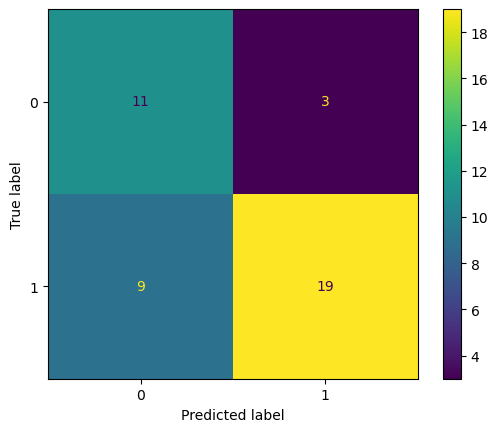

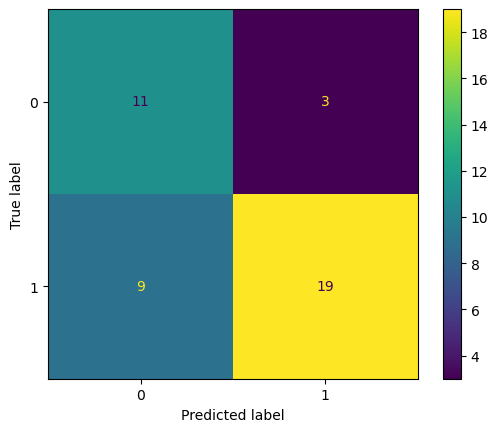

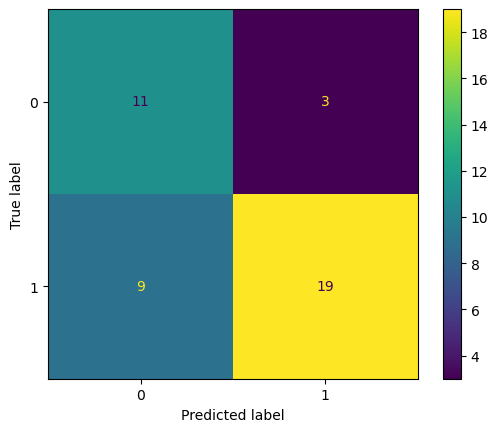

In [48]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [104]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

Open       High        Low      Close  \
Date                                                                    
2022-12-12 00:00:00-05:00   1.151833   3.258681   1.417668   5.700256   
2022-12-13 00:00:00-05:00  14.846272  12.926512   5.710127   5.641205   
2022-12-14 00:00:00-05:00   6.566610   7.757879   3.111030   6.025146   
2022-12-15 00:00:00-05:00   0.187054  -3.642672  -5.434443  -9.175568   
2022-12-16 00:00:00-05:00 -22.910624 -21.791803 -16.027973 -16.677521   

                               Volume  open_close  positive  high_low  \
Date                                                                    
2022-12-12 00:00:00-05:00   9477900.0    4.548423       0.0  1.841013   
2022-12-13 00:00:00-05:00  63044600.0   -9.205067      -1.0  7.216385   
2022-12-14 00:00:00-05:00  26663600.0   -0.541464       0.0  4.646849   
2022-12-15 00:00:00-05:00  42300100.0   -9.362622      -1.0  1.791770   
2022-12-16 00:00:00-05:00  -3924500.0    6.233103       0.0 -5.763830   

                           Open_lag1  High_lag1  Low_lag1  Close_lag1  \
Date                                                                    
2022-12-12 00:00:00-05:00  -4.410557  -2.333243  1.486598   -0.541443   
2022-12-13 00:00:00-05:00   1.151833   3.258681  1.417668    5.700256   
2022-12-14 00:00:00-05:00  14.846272  12.926512  5.710127    5.641205   
2022-12-15 00:00:00-05:00   6.566610   7.757879  3.111030    6.025146   
2022-12-16 00:00:00-05:00   0.187054  -3.642672 -5.434443   -9.175568   

                           Volume_lag1  open_close_lag1  positive_lag1  \
Date                                                                     
2022-12-12 00:00:00-05:00    3475500.0         3.869114            0.0   
2022-12-13 00:00:00-05:00    9477900.0         4.548423            0.0   
2022-12-14 00:00:00-05:00   63044600.0        -9.205067           -1.0   
2022-12-15 00:00:00-05:00   26663600.0        -0.541464            0.0   
2022-12-16 00:00:00-05:00   42300100.0        -9.362622           -1.0   

                           high_low_lag1  Open_lag2  High_lag2  Low_lag2  \
Date                                                                       
2022-12-12 00:00:00-05:00      -3.819841  -8.673467  -7.452694 -4.824091   
2022-12-13 00:00:00-05:00       1.841013  -4.410557  -2.333243  1.486598   
2022-12-14 00:00:00-05:00       7.216385   1.151833   3.258681  1.417668   
2022-12-15 00:00:00-05:00       4.646849  14.846272  12.926512  5.710127   
2022-12-16 00:00:00-05:00       1.791770   6.566610   7.757879  3.111030   

                           Close_lag2  Volume_lag2  open_close_lag2  \
Date                                                                  
2022-12-12 00:00:00-05:00   -3.298096  -16551900.0         5.375371   
2022-12-13 00:00:00-05:00   -0.541443    3475500.0         3.869114   
2022-12-14 00:00:00-05:00    5.700256    9477900.0         4.548423   
2022-12-15 00:00:00-05:00    5.641205   63044600.0        -9.205067   
2022-12-16 00:00:00-05:00    6.025146   26663600.0        -0.541464   

                           positive_lag2  high_low_lag2  Open_lag1_lag2  \
Date                                                                      
2022-12-12 00:00:00-05:00            1.0      -2.628603       -9.165675   
2022-12-13 00:00:00-05:00            0.0      -3.819841       -8.673467   
2022-12-14 00:00:00-05:00            0.0       1.841013       -4.410557   
2022-12-15 00:00:00-05:00           -1.0       7.216385        1.151833   
2022-12-16 00:00:00-05:00            0.0       4.646849       14.846272   

                           High_lag1_lag2  Low_lag1_lag2  Close_lag1_lag2  \
Date                                                                        
2022-12-12 00:00:00-05:00      -12.030549     -10.012362       -13.536865   
2022-12-13 00:00:00-05:00       -7.452694      -4.824091        -3.298096   
2022-12-14 00:00:00-05:00       -2.333243       1.486598        -0.541443   
2022-12-15 00:00:00-05:00        3.

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [105]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2022-12-12 00:00:00-05:00  0.049150  0.310472  0.032064  0.533464  0.361255   
2022-12-13 00:00:00-05:00  1.728804  1.584028  0.585011  0.526506  1.944666   
2022-12-14 00:00:00-05:00  0.713285  0.903157  0.250200  0.571748  0.869258   
2022-12-15 00:00:00-05:00 -0.069182 -0.598653 -0.850613 -1.219414  1.331467   
2022-12-16 00:00:00-05:00 -2.902164 -2.989462 -2.215253 -2.103400 -0.034914   

                           open_close  positive  high_low  Open_lag1  \
Date                                                                   
2022-12-12 00:00:00-05:00    0.796088         1  0.681392  -0.631550   
2022-12-13 00:00:00-05:00   -1.587728         0  2.772398   0.049031   
2022-12-14 00:00:00-05:00   -0.086114         0  1.772855   1.724599   
2022-12-15 00:00:00-05:00   -1.615036         0  0.662236   0.711550   
2022-12-16 00:00:00-05:00    1.088085         0 -2.276874  -0.069014   

                           High_lag1  Low_lag1  Close_lag1  Volume_lag1  \
Date                                                                      
2022-12-12 00:00:00-05:00  -0.426160  0.035262   -0.202020     0.183827   
2022-12-13 00:00:00-05:00   0.310472  0.026383    0.533464     0.361255   
2022-12-14 00:00:00-05:00   1.584028  0.579330    0.526506     1.944666   
2022-12-15 00:00:00-05:00   0.903157  0.244518    0.571748     0.869258   
2022-12-16 00:00:00-05:00  -0.598653 -0.856294   -1.219414     1.331467   

                           open_close_lag1  positive_lag1  high_low_lag1  \
Date                                                                       
2022-12-12 00:00:00-05:00         0.661967            0.0      -1.505511   
2022-12-13 00:00:00-05:00         0.776865            0.0       0.691095   
2022-12-14 00:00:00-05:00        -1.549388           -0.5       2.776925   
2022-12-15 00:00:00-05:00        -0.084034            0.0       1.779856   
2022-12-16 00:00:00-05:00        -1.576037           -0.5       0.671987   

                           Open_lag2  High_lag2  Low_lag2  Close_lag2  \
Date                                                                    
2022-12-12 00:00:00-05:00  -1.124658  -1.079608 -0.768959   -0.515650   
2022-12-13 00:00:00-05:00  -0.607200  -0.413951  0.040783   -0.191564   
2022-12-14 00:00:00-05:00   0.067998   0.313140  0.031938    0.542243   
2022-12-15 00:00:00-05:00   1.730313   1.570200  0.582715    0.535300   
2022-12-16 00:00:00-05:00   0.725277   0.898148  0.249218    0.580439   

                           Volume_lag2  open_close_lag2  positive_lag2  \
Date                                                                     
2022-12-12 00:00:00-05:00    -0.404196         0.889491            0.5   
2022-12-13 00:00:00-05:00     0.186824         0.639782            0.0   
2022-12-14 00:00:00-05:00     0.363958         0.752399            0.0   
2022-12-15 00:00:00-05:00     1.944743        -1.527674           -0.5   
2022-12-16 00:00:00-05:00     0.871118        -0.091410            0.0   

                           high_low_lag2  Open_lag1_lag2  High_lag1_lag2  \
Date                                                                       
2022-12-12 00:00:00-05:00      -1.019086       -1.157417       -1.664250   
2022-12-13 00:00:00-05:00      -1.470613       -1.098492       -1.072779   
2022-12-14 00:00:00-05:00       0.675076       -0.588151       -0.411332   
2022-12-15 00:00:00-05:00       2.712555        0.077759        0.311159   
2022-12-16 00:00:00-05:00       1.738599        1.717211        1.560268   

                           Low_lag1_lag2  Close_lag1_lag2  Volume_lag1_lag2  \
Date                                                                          
2022-12-12 00:00:00-05:00      -1.405898        -1.709538         -0.488682   
2022-12-13 00:00:00-05:00      -0.749616        -0.511828         -0.404196   
2022-12-14 00:00:00-05:00       0

### Partition

In [106]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (42, 63), (200,), (42,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters

In [141]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16, 
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)', 
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnv

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              random_state=14, solver='sgd')

##### Fit parameters to MLP model

In [143]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.93      0.89      0.91        28

    accuracy                           0.88        42
   macro avg       0.86      0.88      0.87        42
weighted avg       0.88      0.88      0.88        42



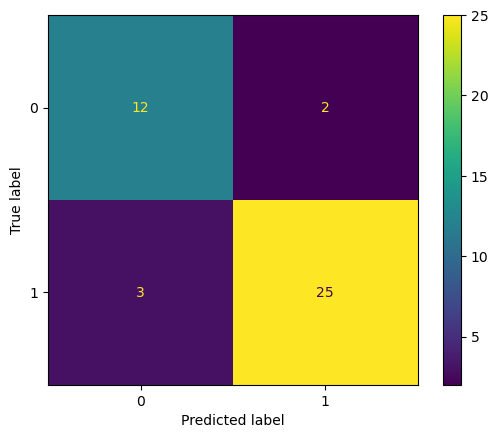

In [144]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.) 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.96      0.96      0.96        28

    accuracy                           0.95        42
   macro avg       0.95      0.95      0.95        42
weighted avg       0.95      0.95      0.95        42



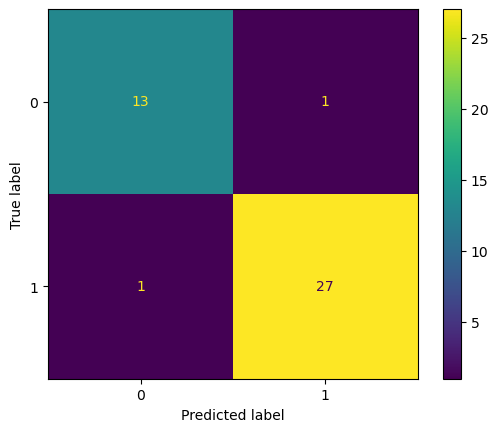

In [183]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

## Amazon  - Gabi in progress

In [49]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

{'currency': 'USD',
 'symbol': 'AMZN',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 863703000,
 'regularMarketTime': 1701205201,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 147.03,
 'chartPreviousClose': 143.9,
 'previousClose': 147.73,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1701162000,
   'end': 1701181800,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1701181800,
   'end': 1701205200,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1701205200,
   'end': 1701219600,
   'gmtoffset': -18000}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-11-22 00:00:00-05:00 2023-11-21 04:00:00-05:00 2023-11-21 09:30:00-05:00   
 2023-11-24 00:00:00-05:00 2023-11-22 04:00:00

In [50]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

Open       High        Low      Close  \
Date                                                                    
2018-11-29 00:00:00-05:00  83.749496  84.499496  82.616501  83.678497   
2018-11-30 00:00:00-05:00  83.974998  84.800003  83.324997  84.508499   
2018-12-03 00:00:00-05:00  88.473000  88.917000  86.500000  88.617996   
2018-12-04 00:00:00-05:00  87.800003  88.516998  83.250000  83.419998   
2018-12-06 00:00:00-05:00  80.743500  85.052498  80.492500  84.959503   

                              Volume  Dividends  Stock Splits  
Date                                                           
2018-11-29 00:00:00-05:00  132264000        0.0           0.0  
2018-11-30 00:00:00-05:00  115236000        0.0           0.0  
2018-12-03 00:00:00-05:00  137246000        0.0           0.0  
2018-12-04 00:00:00-05:00  173890000        0.0           0.0  
2018-12-06 00:00:00-05:00  175788000        0.0           0.0

Open        High         Low       Close  \
Date                                                                        
2023-11-21 00:00:00-05:00  143.910004  144.050003  141.500000  143.899994   
2023-11-22 00:00:00-05:00  144.570007  147.740005  144.570007  146.710007   
2023-11-24 00:00:00-05:00  146.699997  147.199997  145.320007  146.740005   
2023-11-27 00:00:00-05:00  147.529999  149.259995  146.880005  147.729996   
2023-11-28 00:00:00-05:00  146.979996  147.599899  145.529999  147.029999   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-11-21 00:00:00-05:00  71226000        0.0           0.0  
2023-11-22 00:00:00-05:00  45669100        0.0           0.0  
2023-11-24 00:00:00-05:00  22378400        0.0           0.0  
2023-11-27 00:00:00-05:00  53762400        0.0           0.0  
2023-11-28 00:00:00-05:00  41217724        0.0           0.0

Open         High          Low        Close        Volume  \
count  1257.000000  1257.000000  1257.000000  1257.000000  1.257000e+03   
mean    126.488368   128.048712   124.814940   126.447173  7.766829e+07   
std      31.793658    32.079866    31.423970    31.711742  3.524004e+07   
min      67.300003    69.801498    65.349998    67.197998  1.762600e+07   
25%      94.804497    95.875504    93.638000    94.891502  5.404400e+07   
50%     125.010002   126.730003   123.660004   125.300003  6.702800e+07   
75%     158.350006   159.937500   156.250000   158.100494  9.166200e+07   
max     187.199997   188.654007   184.839493   186.570496  3.113460e+08   

       Dividends  Stock Splits  
count     1257.0   1257.000000  
mean         0.0      0.015911  
std          0.0      0.564108  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0     20.000000

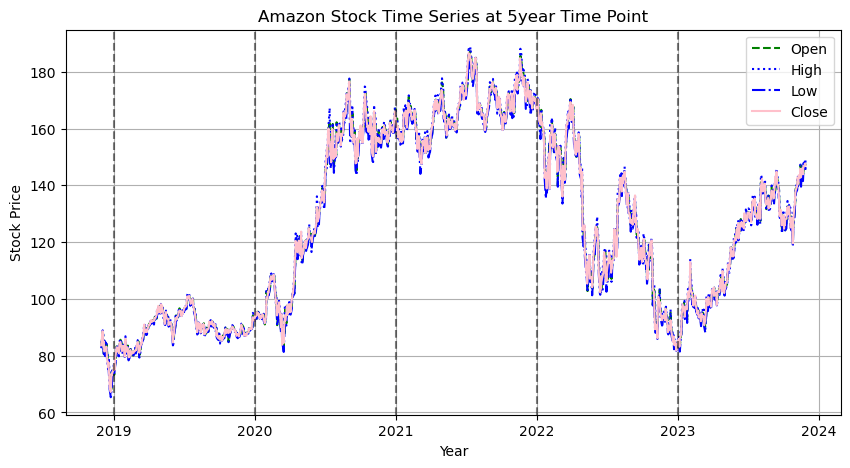

In [51]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [53]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.459791
p-value: 0.553300
Critical Values:
{'1%': -3.4348307241414218, '5%': -2.863518943068048, '10%': -2.5678235713684194}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [54]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

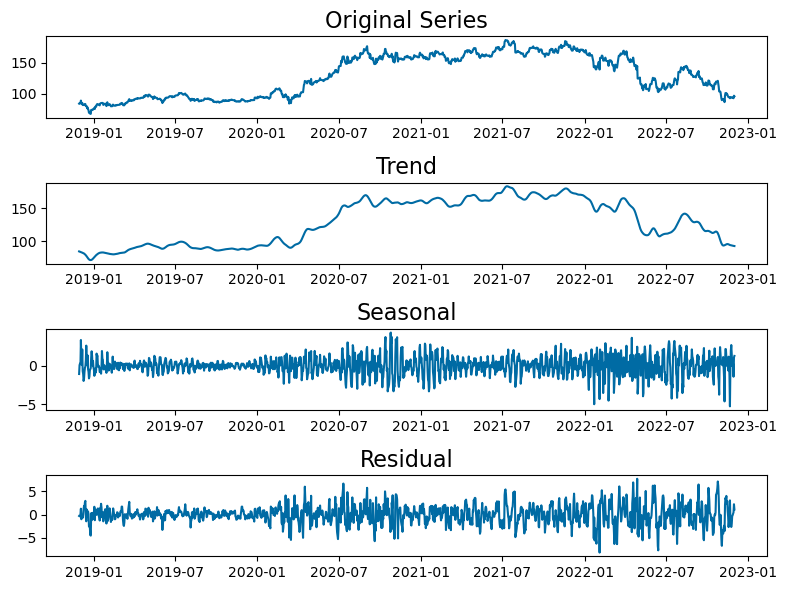

In [55]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [56]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

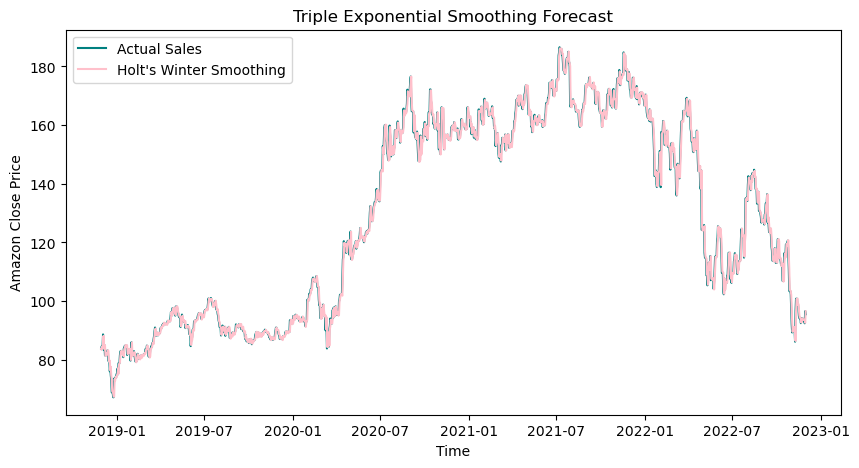

In [57]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

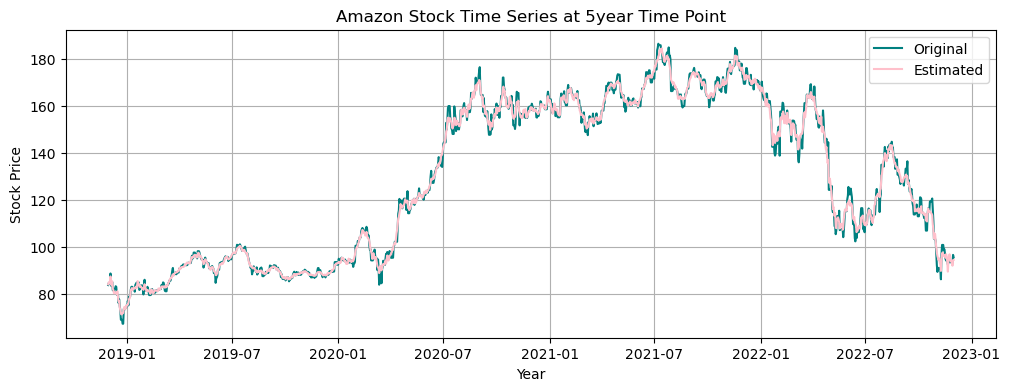

In [58]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal # from STL
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(17775.0, 19358.0)

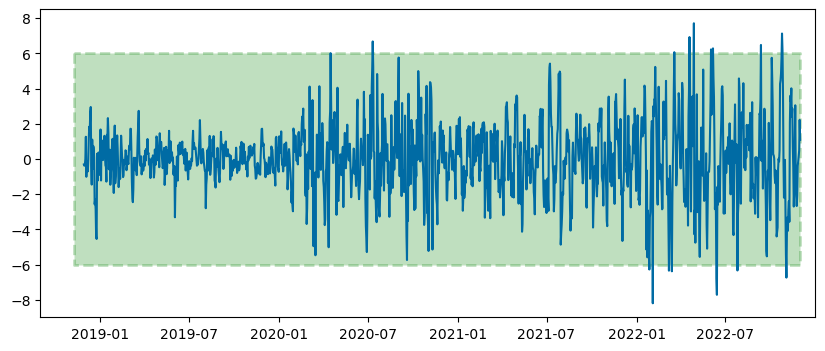

In [60]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [61]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

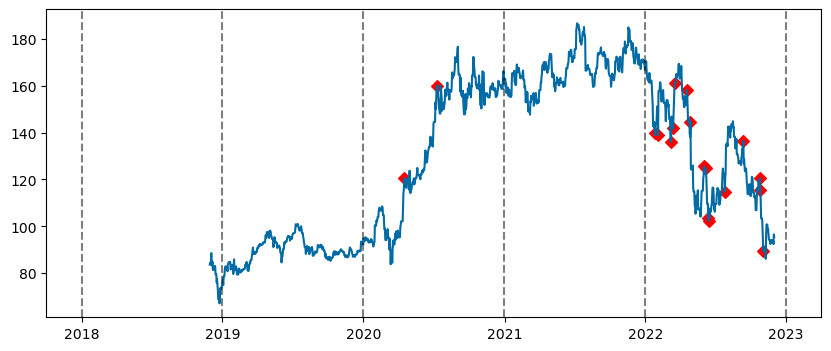

In [62]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
#plt.xlabel('Year')
#plt.ylabel('Closing Price')

In [63]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

Close
Date                                 
2020-04-16 00:00:00-04:00  120.409500
2020-07-11 00:00:00-04:00  160.000000
2022-01-27 00:00:00-05:00  139.637497
2022-02-03 00:00:00-05:00  138.845505
2022-03-08 00:00:00-05:00  136.014496

### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

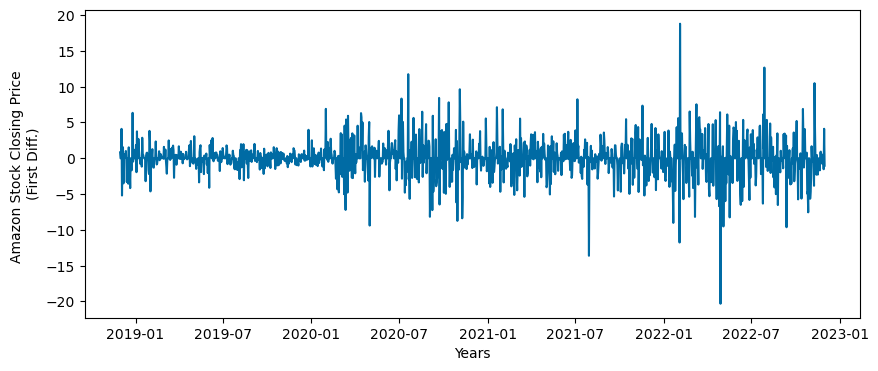

In [64]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [65]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -40.071903
p-value: 0.000000
Critical Values:
{'1%': -3.4348307241414218, '5%': -2.863518943068048, '10%': -2.5678235713684194}
Time series is stationary


### Selecting a Model

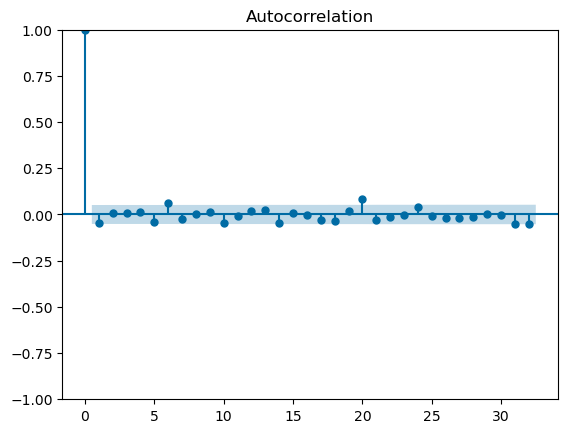

None

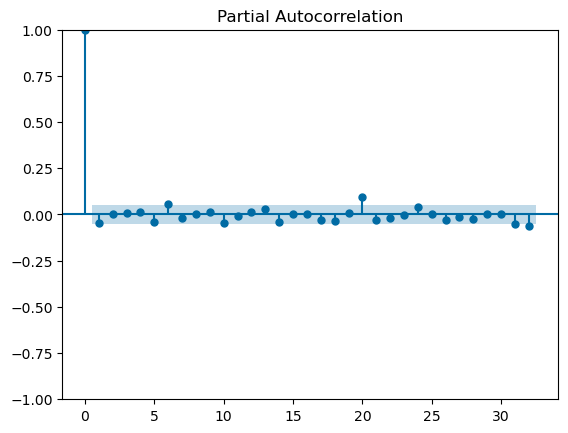

None

In [66]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [67]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7831.316, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7359.631, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7829.316, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7173.581, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7073.205, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7035.824, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6963.476, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6961.476, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7033.824, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.26 s

In [68]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1463
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3474.738
Date:                Tue, 28 Nov 2023   AIC                           6961.476
Time:                        17:14:51   BIC                           6993.201
Sample:                    11-30-2018   HQIC                          6973.310
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8781      0.018    -49.640      0.000      -0.913      -0.843
ar.L2         -0.7057      0.025    -28.798      0.000      -0.754      -0.658
ar.L3         -0.5282      0.029    -18.154      0.0

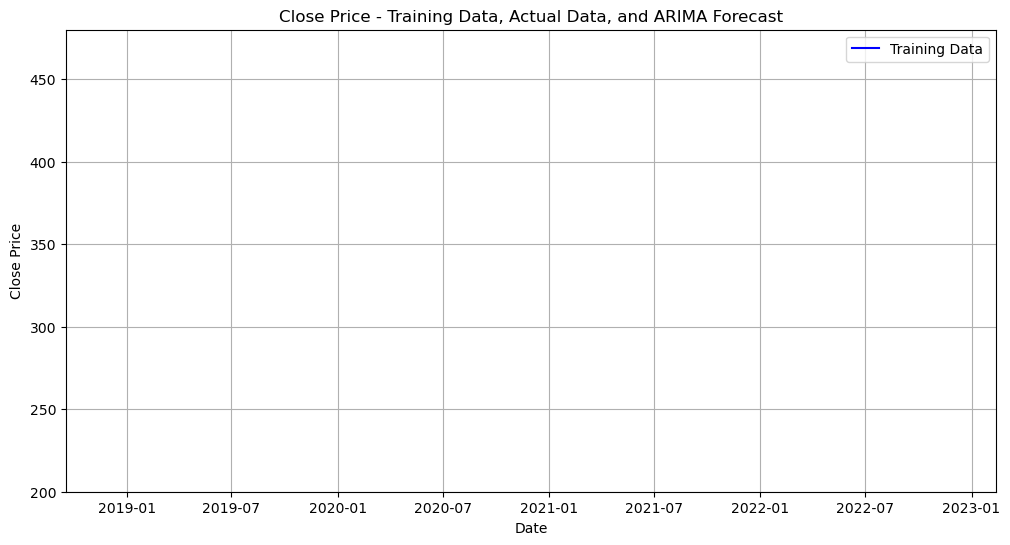

In [69]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    